### Santander Customer Transaction Prediction
---
Can you identify who will make a transaction?

This is a case study, proposed by Santander Bank in a Kaggle competition, where we need to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

[Kaggle Dataset](https://www.kaggle.com/c/santander-customer-transaction-prediction/overview)

In [28]:
# %pip install ibmdbpy
#%matplotlib inline
#%pip install xgboost
#%pip install lightgbm

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
import lightgbm as lgb
import xgboost as xgb
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

In [70]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

### Procedures:
---
- Exploratory Data Analysis
- Feature Engineering/Selection
- Build Model
- Evaluate Perfomance
- Generate Pickle and Export Model

In [71]:
train_data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [72]:
test_data.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [73]:
print('Number of Training = {}'.format(train_data.shape[0]))
print('Number of Test = {}\n'.format(test_data.shape[0]))

#target columns
train_data.columns

Number of Training = 200000
Number of Test = 200000



Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

#### Checking for missing data
---

In [74]:
pd.isnull(train_data).sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

In [75]:
#Check for the missing values: 
pd.isnull(test_data).sum()

ID_code    0
var_0      0
var_1      0
var_2      0
var_3      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 201, dtype: int64

In [76]:
train_data.describe(include="all")

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
unique,200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,train_142624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,NaN,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,NaN,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,NaN,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,NaN,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,NaN,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800


In [77]:
test_data.describe(include="all")

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
unique,200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,test_59315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,NaN,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,NaN,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,NaN,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,NaN,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,NaN,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400


#### Data Visualization
---

From the previous analysis above and the description of the data, we can conclude that:
- All features have numerical values;
- We don't have missing values;
- Our prediction is a binary prediction;
- All values are unique;
- There are 10,049% target valute with value __1__ (unbalanced train data);

**To better understand the data, which is _anonymously_. I will continue with some visualizations of the data distributions, such as the average, the maximum and minimum in each set: training and testing. Basically, we want to know what this data looks like visually.**

In the following two plots, we'll see the first 12 features distributions. The first, we will see the density of the probability of each variable with target 0 and 1 in the training data. And the second, the density of the distribution between the training and test sets.

In [78]:
def plotting_feature_distribution(df1, df2, lb1, lb2, features):
    
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(24,14))

    count = 0
    for feature in features:
        count = count + 1
        
        plt.subplot(3,6,count)
        
        sns.kdeplot(data=df1[feature], bw=1 ,cut=3, palette="crest", label=lb1)
        sns.kdeplot(data=df2[feature], bw=1, cut=3, palette="crest", label=lb2)
        #bw_adjust=3, cut=3, fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0)
        locs, labels = plt.xticks()
        
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
        plt.legend()

<Figure size 432x288 with 0 Axes>

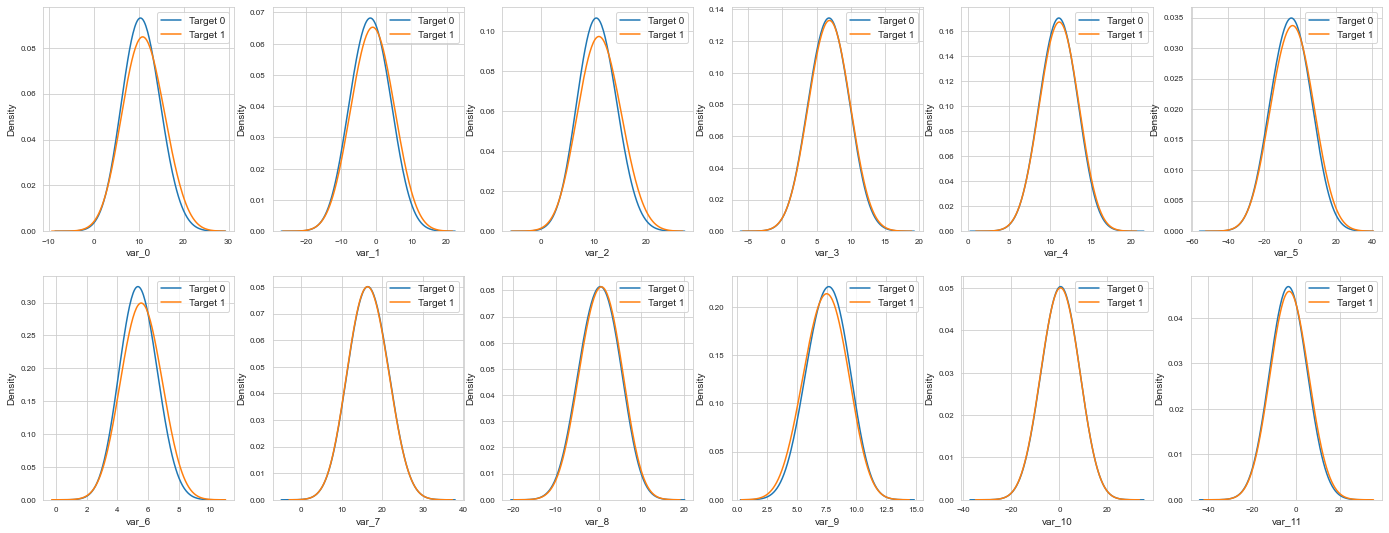

In [79]:
target0 = train_data.loc[train_data['target'] == 0]
target1 = train_data.loc[train_data['target'] == 1]

features = train_data.columns.values[2:14]
plotting_feature_distribution(target0, target1, "Target 0", "Target 1", features)

<Figure size 432x288 with 0 Axes>

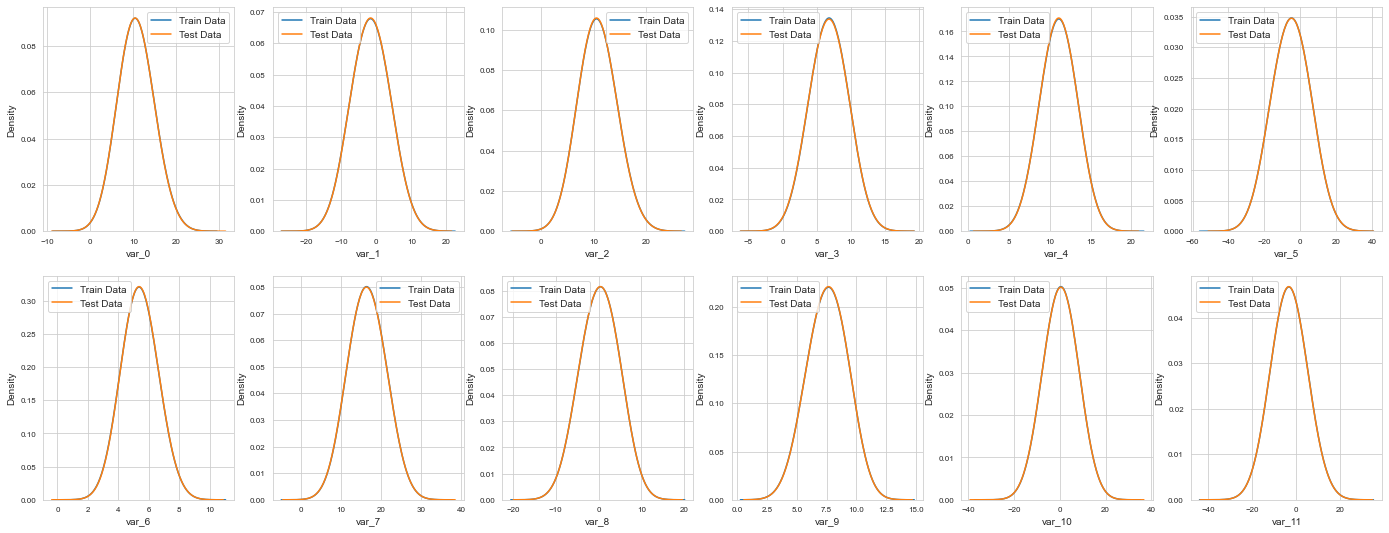

In [80]:
#The first 12 features distribuitions, density of each dataset
features = train_data.columns.values[2:14]
plotting_feature_distribution(train_data, test_data, "Train Data", "Test Data", features)

For each feature, we can see a very short difference between the density of the features when the target is 0 or 1. Looking at the training and test data, they have a very close density. As the data is anonymous and we don't know much about each feature, we can conclude that this dataset had a good pre-processing of the data, but not necessarily that they have been normalized.

**Visualization of the distribution of maximum and minimum values, per column in the test and training data.**

In [81]:
def plotting_max_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Max Values in Train and Test data (COLUMN)")
    sns.distplot(df1[features].max(axis=0), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].max(axis=0), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')
    
def plotting_min_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Min Values in Train and Test data (COLUMN)")
    sns.distplot(df1[features].min(axis=0), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].min(axis=0), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')
    
def plotting_mean_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Mean Values in Train and Test data (COLUMN)")
    sns.distplot(df1[features].mean(axis=0), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].mean(axis=0), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large',  title_fontsize='25')
    
def plotting_std_distribution(df1, df2, features):
    
    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Standard deviation in Train and Test data (COLUMN)")
    sns.distplot(df1[features].std(axis=0), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].std(axis=0), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')

**Visualization of the distribution of maximum and minimum values, per column in the test and training data.**

In [82]:
def plotting_max_row_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Max Values in Train and Test data (ROW)")
    sns.distplot(df1[features].max(axis=1), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].max(axis=1), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')
    
def plotting_min_row_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Min Values in Train and Test data (ROW)")
    sns.distplot(df1[features].min(axis=1), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].min(axis=1), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')
    
def plotting_mean_row_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Mean Values in Train and Test data (ROW)")
    sns.distplot(df1[features].mean(axis=1), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].mean(axis=1), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')
    
def plotting_std_row_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Standard deviation in Train and Test data (ROW)")
    sns.distplot(df1[features].std(axis=1), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].std(axis=1), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')

In [83]:
features = train_data.columns.values[2:200]

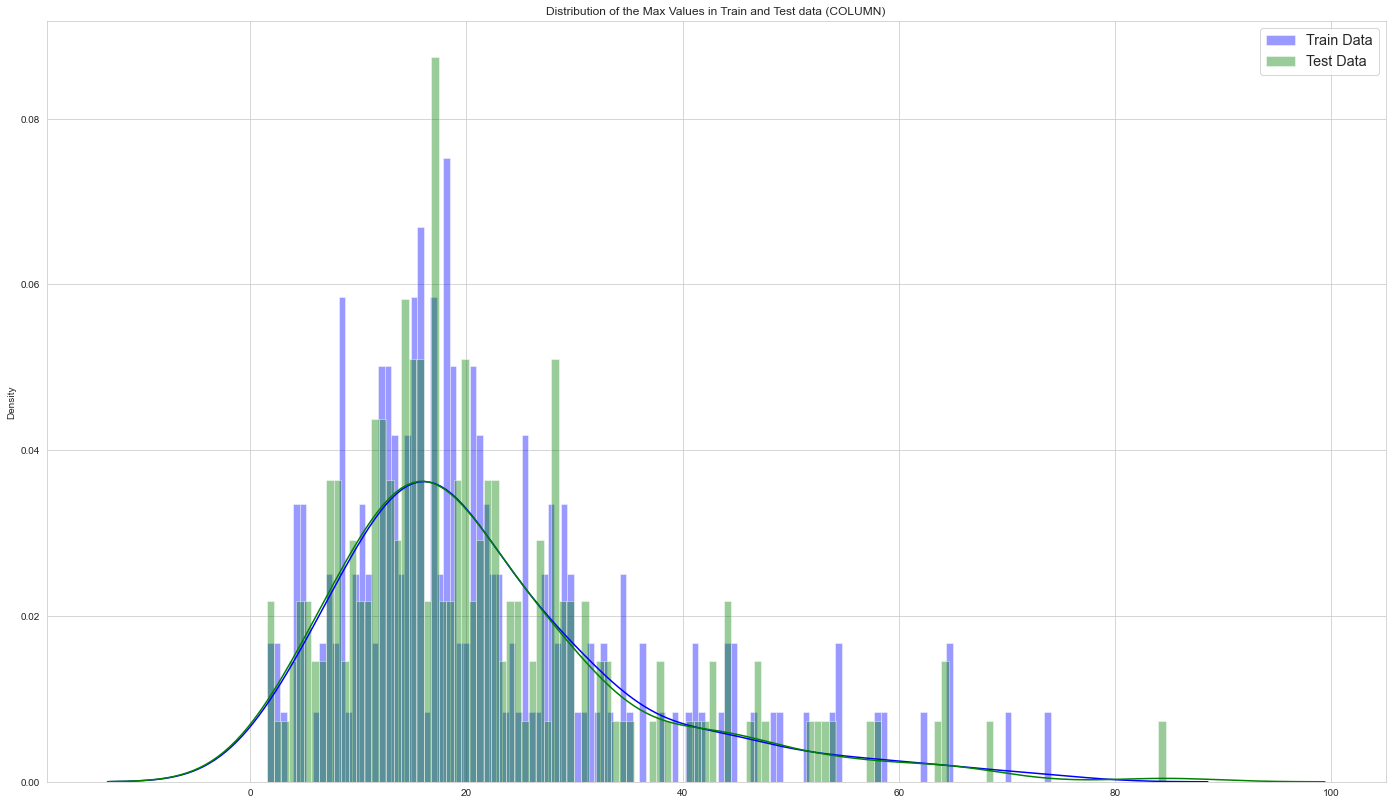

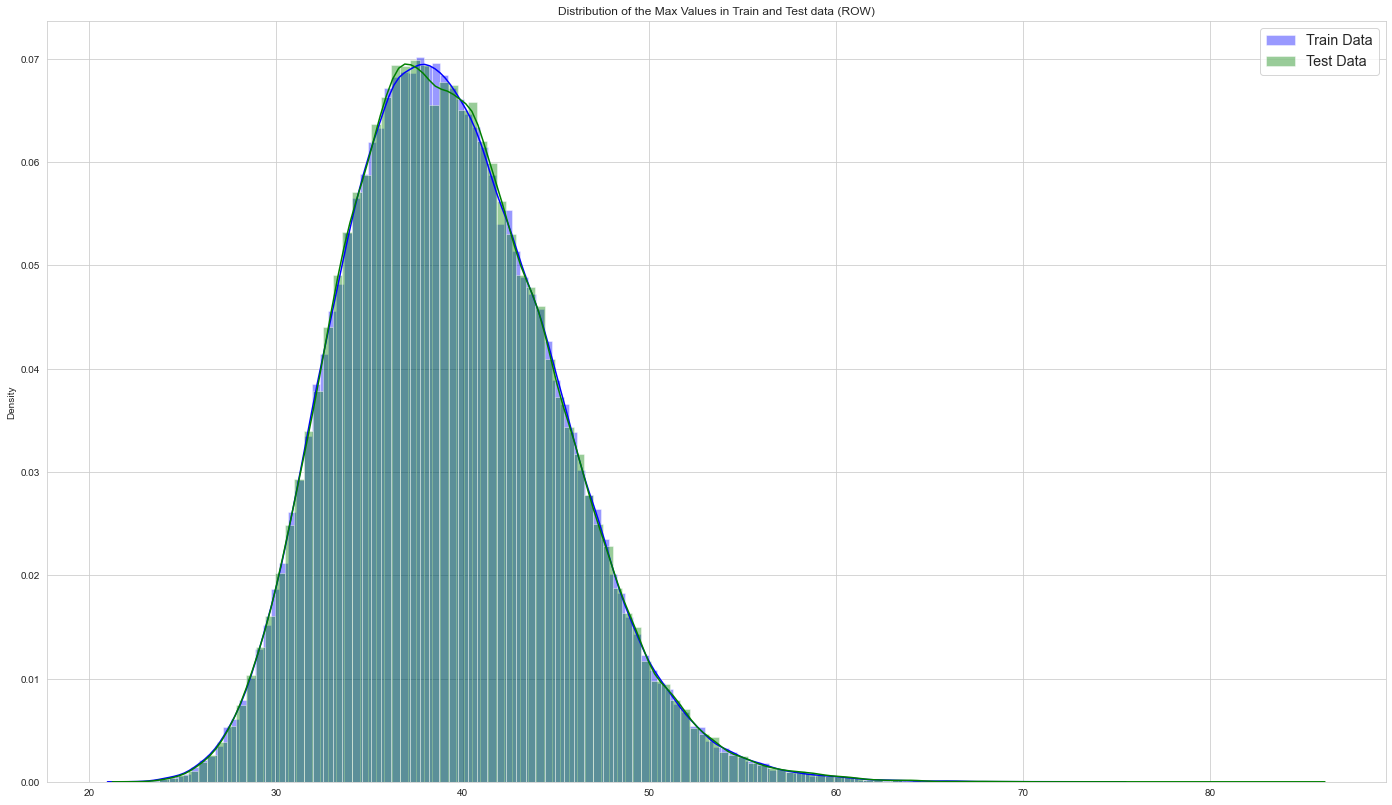

In [84]:
plotting_max_distribution(train_data, test_data, features)
plotting_max_row_distribution(train_data, test_data, features)

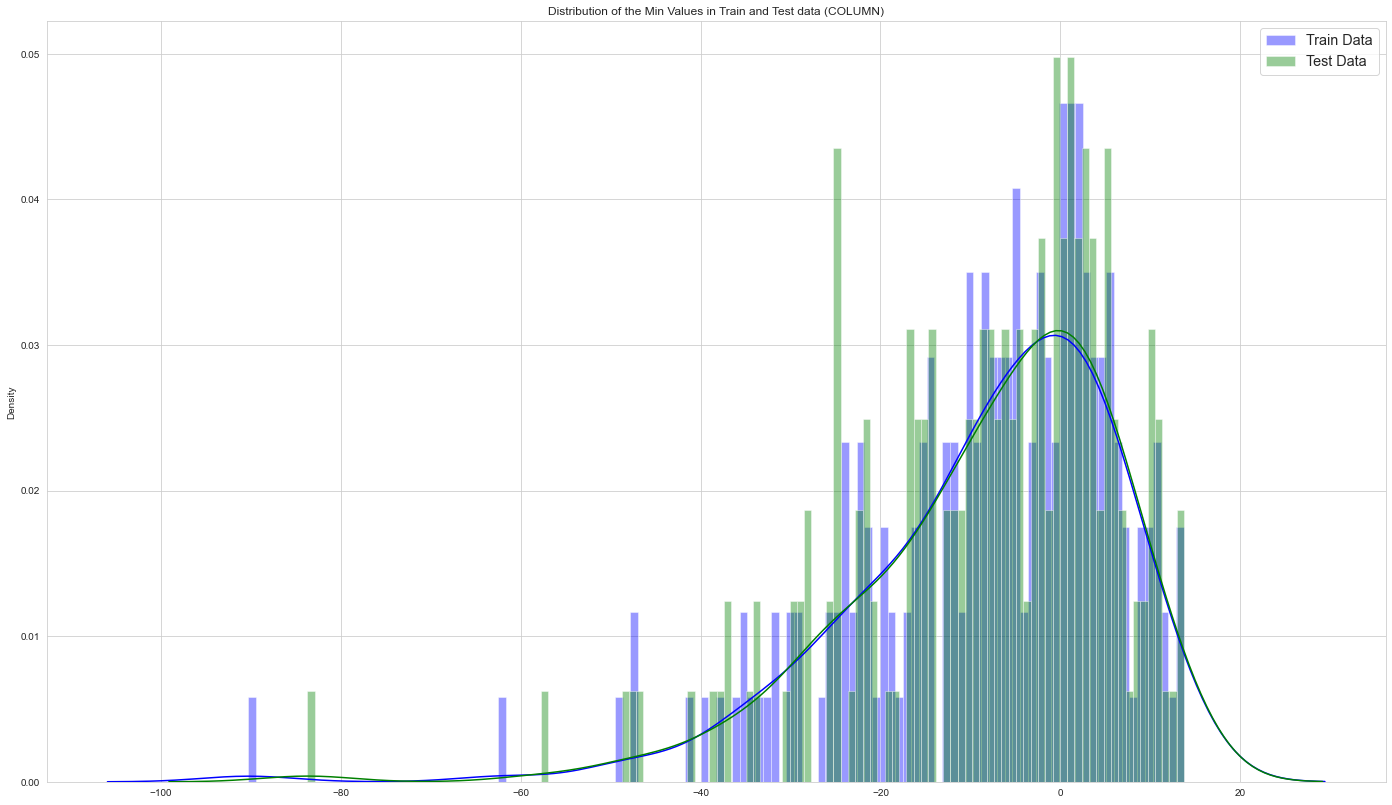

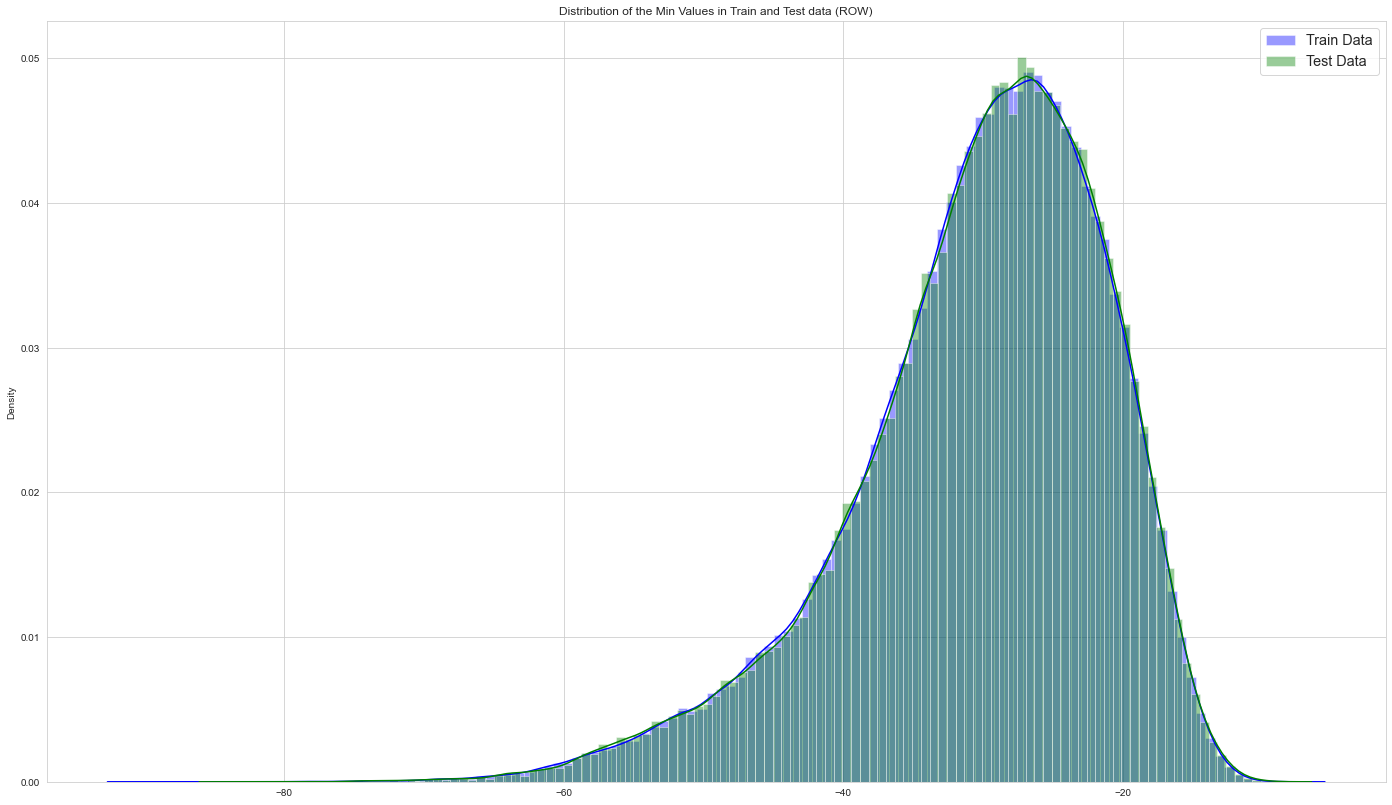

In [85]:
plotting_min_distribution(train_data, test_data, features)
plotting_min_row_distribution(train_data, test_data, features)

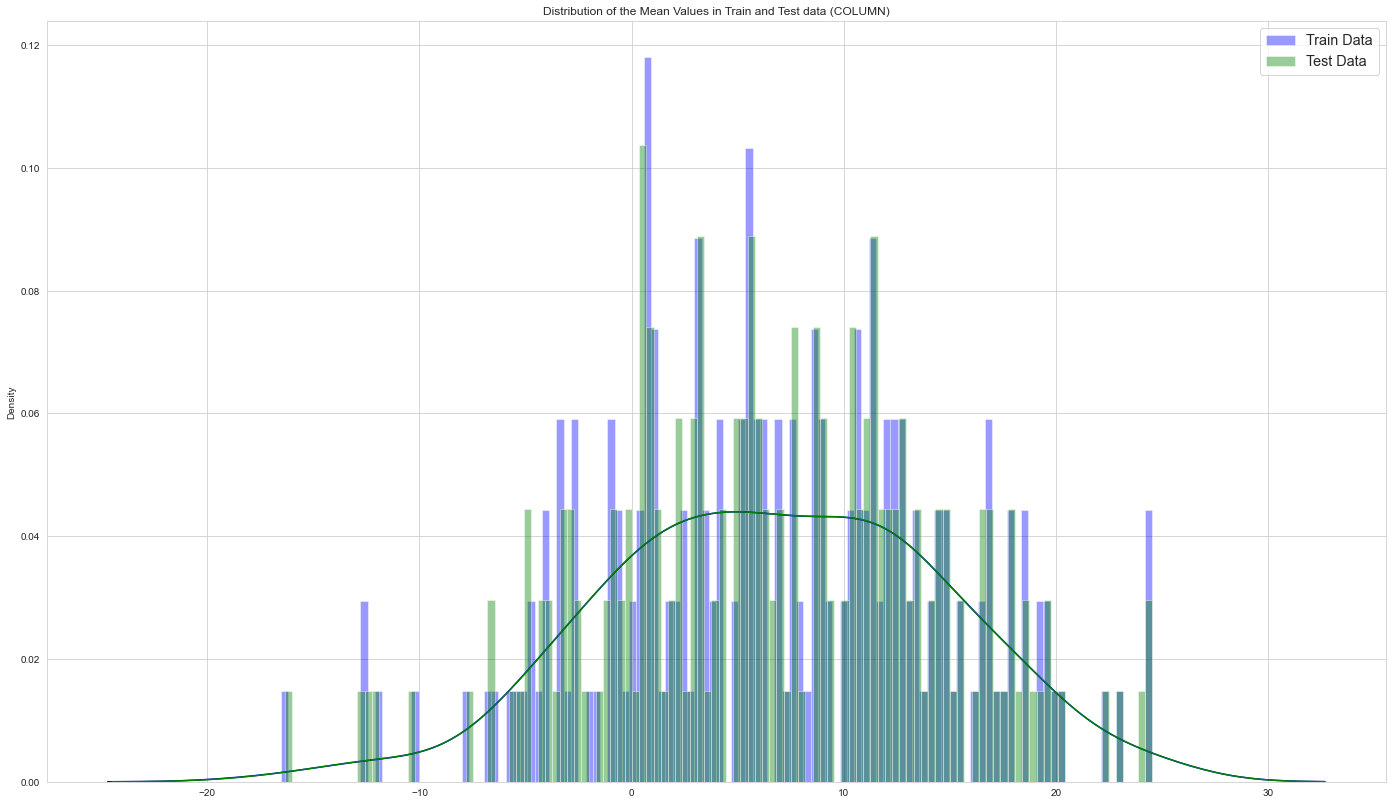

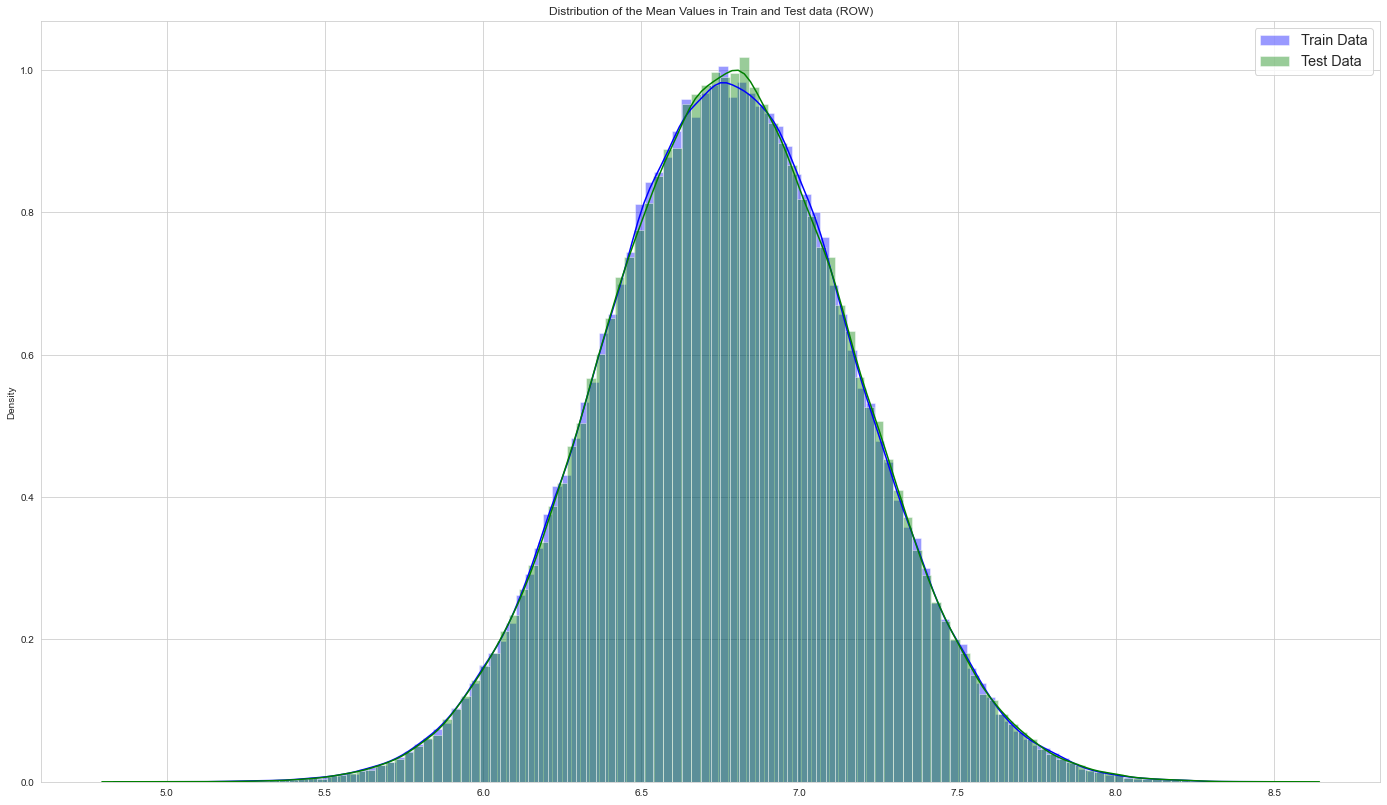

In [86]:
plotting_mean_distribution(train_data, test_data, features)
plotting_mean_row_distribution(train_data, test_data, features)

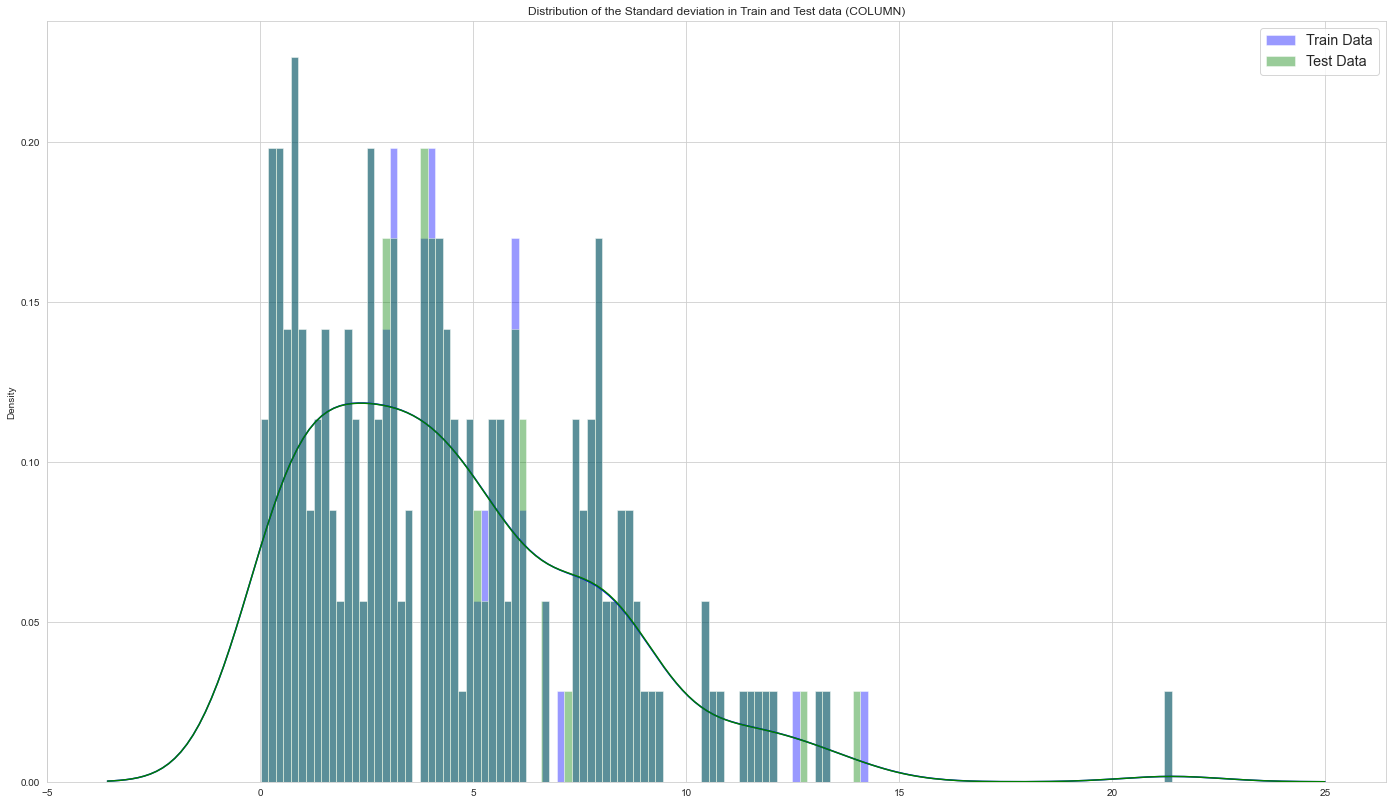

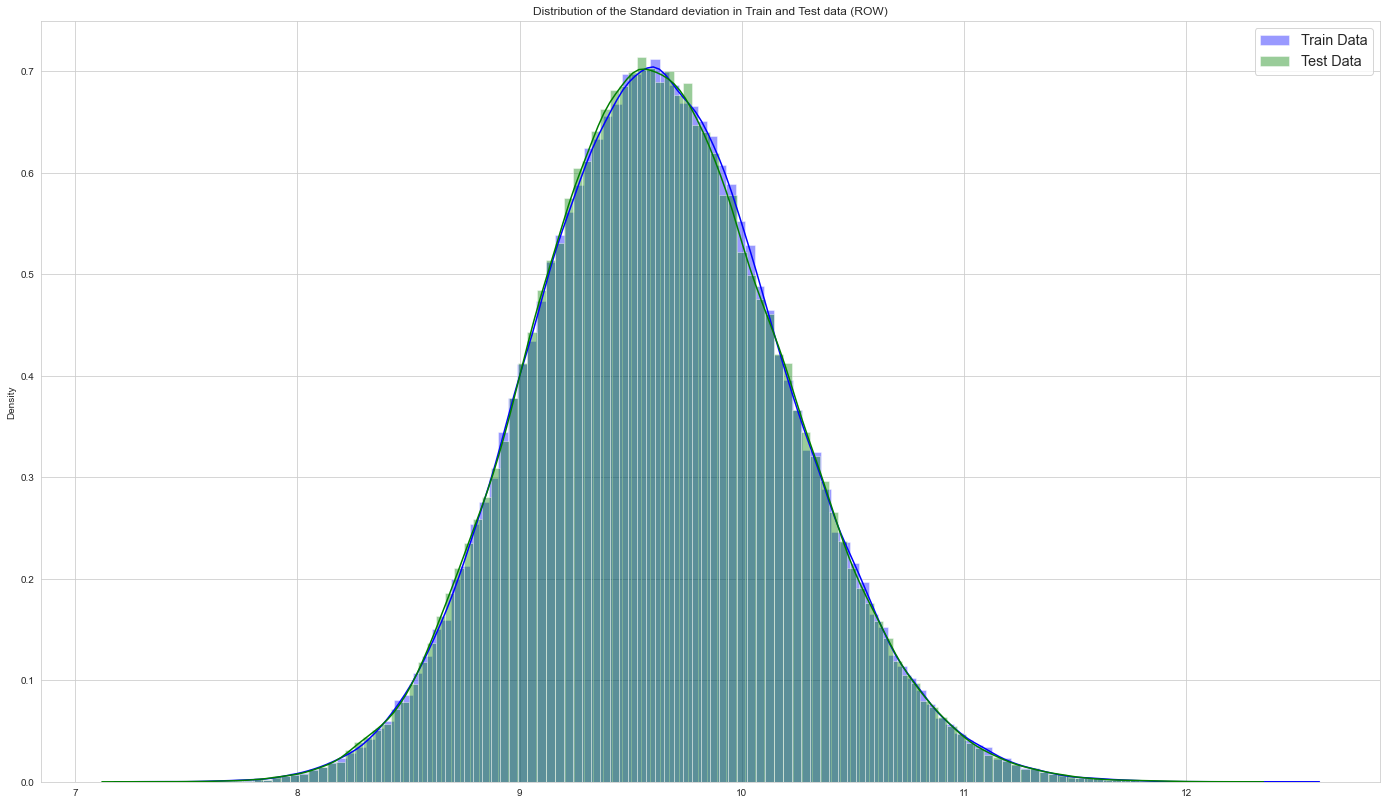

In [87]:
plotting_std_distribution(train_data, test_data, features)
plotting_std_row_distribution(train_data, test_data, features)

**When we observe a low profile of each feature in training and testing, they have very close distribution. But looking at it in a very general way, they are not the same. 
The curves above shows us the maximum, minimum, mean and standard deviation values of the distribution in the training and test data.**

Note: In this dataset, the bank needs to predict whether customers will make any specific transactions in the future, regardless of the money transacted. My guess, is that there may be a set of transactions that they want to monitor or something like that, but it is not possible to know why they have negative or positive data, and what they mean. I believe that this can also be a time series, with lists of transactions made over a period of time. And we must predict whether the customer will carry out this transaction in the future again or not, given his previous transactions.

#### Feature Engineering/Selection
---
Feature engineering is a process of transforming the given data into a form which is more separable for a machine learning model. 

Feature Engineering Process: 
- Brainstorming features to create;
- Checking how the features work with your model;
- Improving your features if needed;
- Create more features until the work is done;

In this case, it is difficult to decide, for example, which features to put together to generate a new feature, the data is very obscure and we do not have the name of the features. So there is no point in making this interaction since the number of features is very huge. I also don't see an option to group feature types or perform feature encoding. 

At this point I will not make a features selection, because the nature of the data does not give me much confidence that it will be a good choice at the moment. But for the model that I will use, [**Gini Index**](https://pythonhosted.org/ibmdbpy/feature_selection.html#gini-index) I believe it would be a good choice, if the data were not so obscure.

_The Gini index, also known as the Gini coefficient or Gini ratio, is a measure commonly used in decision trees to decide what is the best attribute to split the current node for an efficient decision tree construction. It was developed by Corrado Gini in 1912. The Gini index is a measure of statistical dispersion and can be interpreted as a measure of impurity for an attribute._

#### Light Gradient Boosting Machine
---
The model I chose to train this data was LightGBM is a distributed and efficient gradient boosting framework that uses tree-based learning. 

- Faster training speed and higher efficiency
- Lowe memory usage
- Better accuracy
- Handles missing values
- Support of parallel and GPU Learning
- Capable of handling large-scale data
- Handles regression and classification problems
- Works for imbalanced data by setting is_unbalance=false


In [88]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=42)
features = [c for c in train_data.columns if c not in ["ID_code", "target"]]
target = train_data["target"]

param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

Out-of-fold prediction is a prediction by the model during the k-fold cross-validation procedure.
If performed correctly, there will be one prediction for each example in the training dataset. 

In [49]:
oof = np.zeros(len(train_data))
predictions = np.zeros(len(test_data))

# Generate train and validation set indices to iterate on train values and target values.
for counter_, (trn_idx, val_idx) in enumerate(folds.split(train_data.values, target.values)):
    print("Fold {}".format(counter_))
    
    train = lgb.Dataset(train_data.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val = lgb.Dataset(train_data.iloc[val_idx][features], label=target.iloc[val_idx])
    
    #model classifier
    classifier = lgb.train(param, train, 1000000, valid_sets = [train, val], verbose_eval=5000, early_stopping_rounds = 4000)
    
    oof[val_idx] = classifier.predict(train_data.iloc[val_idx][features], num_iteration=classifier.best_iteration)
    predictions += classifier.predict(test_data[features], num_iteration=classifier.best_iteration) / folds.n_splits

Fold 0
[LightGBM] [Info] Number of positive: 18089, number of negative: 161911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 4000 rounds
[5000]	training's auc: 0.928682	valid_1's auc: 0.895515
[10000]	training's auc: 0.948601	valid_1's auc: 0.899111
[15000]	training's auc: 0.963476	valid_1's auc: 0.899321
Early stopping, best iteration is:
[14786]	training's auc: 0.962897	valid_1's auc: 0.899373
Fold 1
[LightGBM] [Info] Number of positive: 18089, number of negative: 161911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_row_wise=true` to remove the ove

#### Evaluation Metric
---

To measure this prediction, I will use the Area under the ROC curve (AUC): Larger the area under the ROC curve, the better our model is! The way to think about this is the following: if we had a model which produced an ROC curve that had a single point at (1,0), the upper left corner, representing a true positive rate of one and a false positive rate of zero, this would be a great model!

The picture[*](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) bellow show how this AUC is defined. Basically, when the threshold = "0" (p = 0), the model predicts "1" for all the data, which means the true positive rate is equal to the false positive rate, is equal to one. When the threshold = "1", the model predicts "0" for all data, which means that both true and false positive rates are "0". If we vary the threshold between these two extremes, we get a series of diferent false positive and true positive rates.

<img src="./img/ROC_curves.png" width="500" style="float:left"/>

In [89]:
print("Cross Validation Score: {:<8.5f}".format(roc_auc_score(target, oof)))

Cross Validation Score: 0.89987 


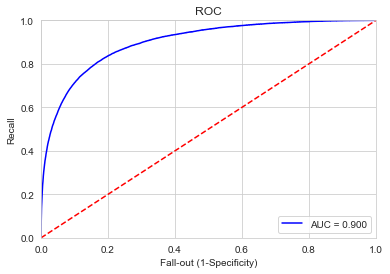

In [90]:
#Print Area Under Curve
plt.figure()

false_positive_rate, recall, thresholds = roc_curve(target, oof)
roc_auc = auc(false_positive_rate, recall)

plt.title('ROC')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

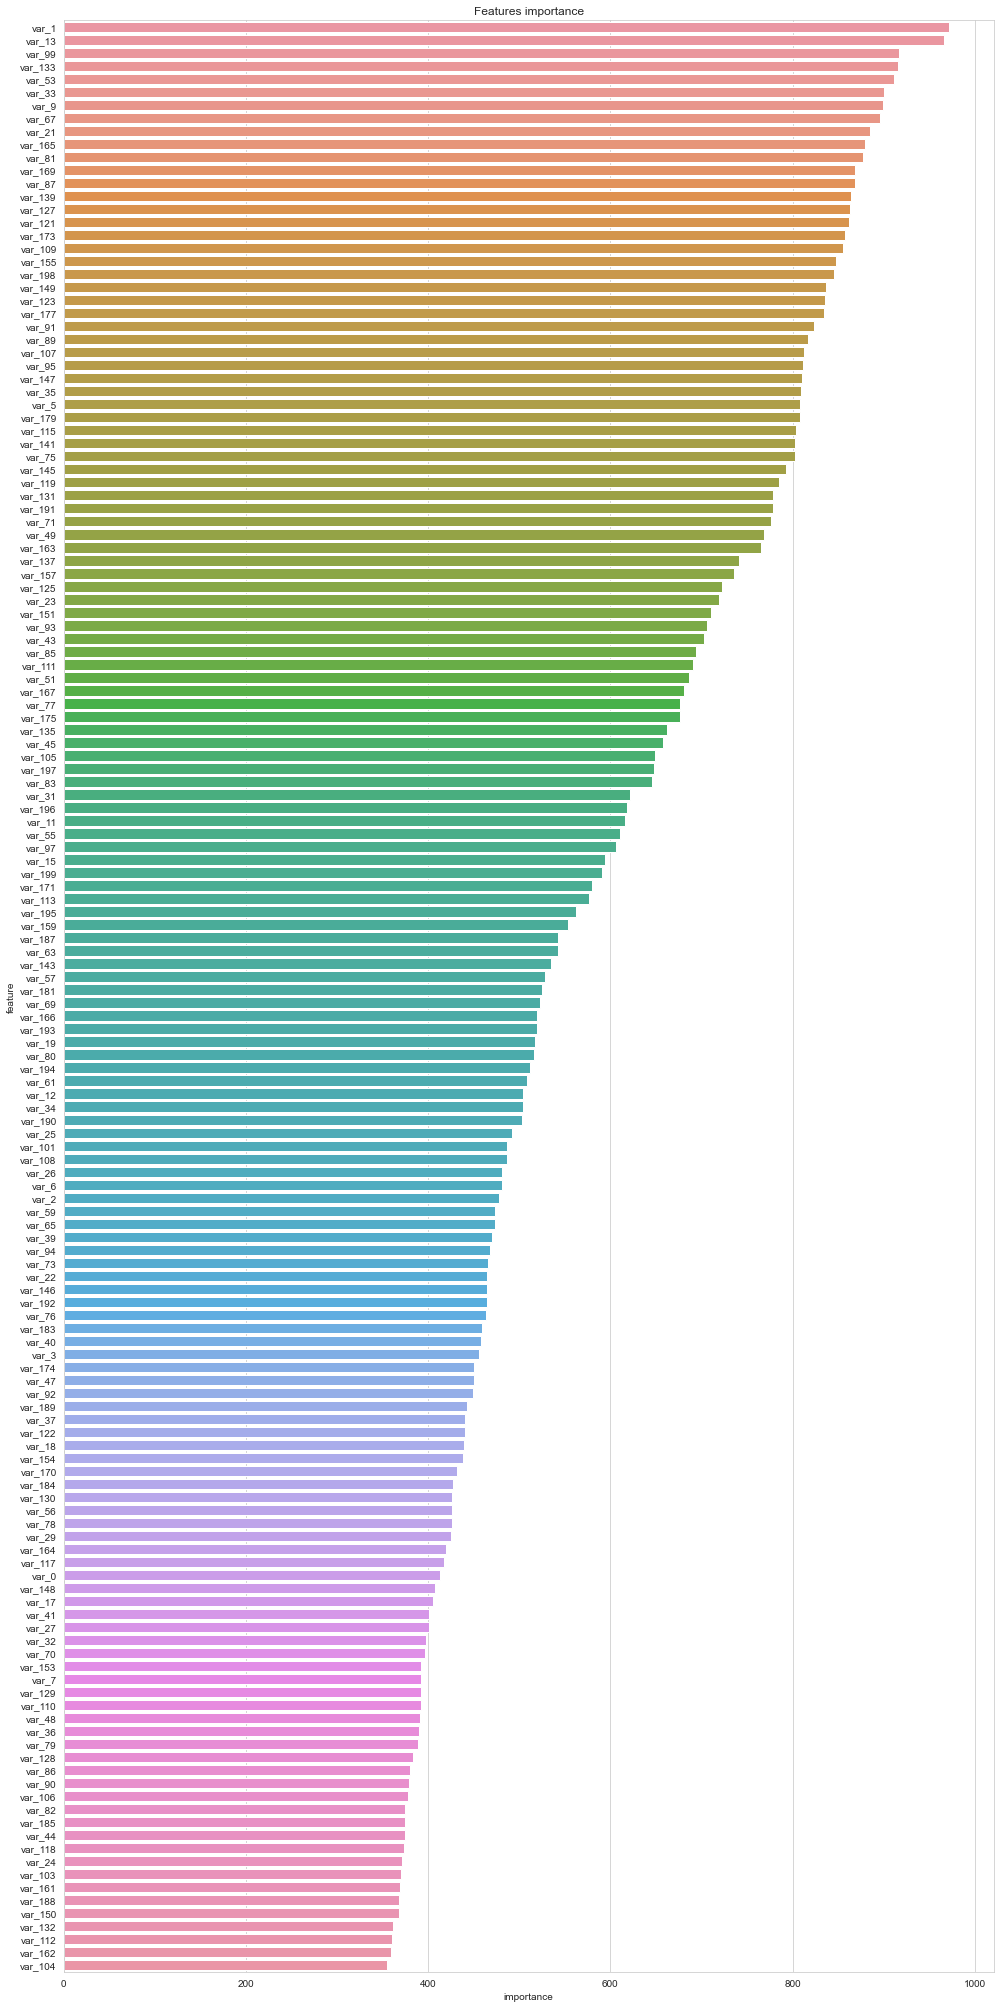

In [57]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = features
feature_importance["importance"] = classifier.feature_importance()

columns = (feature_importance[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)

best_features = feature_importance.loc[feature_importance.feature.isin(columns)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance')
plt.tight_layout()
plt.savefig('featureimportance.png')

In [66]:
#Export LightGBM Model
filename = 'lgbm.pkl'
pickle.dump(classifier, open(filename, 'wb'))

In [91]:
#Submission File for Kaggle (optional for this analysis)

submission = pd.DataFrame({"ID_code": test_data.ID_code.values})
submission["target"] = predictions
submission.to_csv("submission.csv", index=False)

References: 
- [Feature Selection](https://pythonhosted.org/ibmdbpy/feature_selection.html)
- [Exporting Models for Prediction](https://cloud.google.com/ai-platform/prediction/docs/exporting-for-prediction?hl=pt-br)
- [xgboost vs lgbm: Parameters](https://sites.google.com/view/lauraepp/parameters?authuser=0)